In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [473]:
txt_file = 'RelabDatabase2020Dec31/data/jeh/pq/capq03.txt'
df = pd.read_table(txt_file, sep='\t', skiprows=2, names = ['wavelength', 'reflectance'])

# Convert wavelength from micron to nanometer
df['wavelength'] = df['wavelength'].apply(lambda x: int(x * 1000))

# Material files used for testing
"""

txt_file = 'RelabDatabase2020Dec31/data/asr/sr/bkr1sr030.txt' starts from 300, step 5

txt_file = 'RelabDatabase2020Dec31/data/awb/mt/bkr1mt168a.txt' starts from 280, step 5

txt_file = 'RelabDatabase2020Dec31/data/jeh/pq/capq03.txt' starts from 300 ends at 2500, step 5

"""


# Group by wavelength to use wavelength as index
gbw = df.groupby('wavelength').mean()
gbw.head()

,reflectance
wavelength,
300,0.59258
305,0.59681
310,0.60422
315,0.61314
320,0.61801


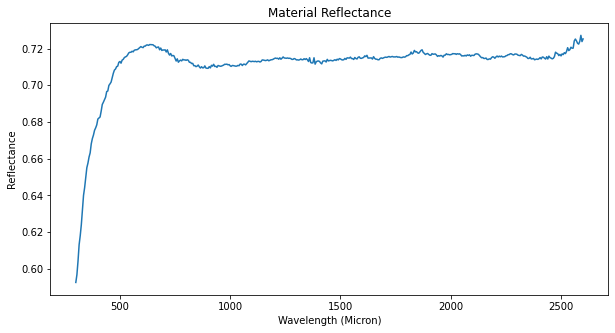

In [475]:
plt.figure(figsize=(10,5))
plt.title('Material Reflectance')
plt.plot(gbw.index, gbw['reflectance'])
plt.xlabel('Wavelength (Micron)')
plt.ylabel('Reflectance')
plt.show()

In [506]:
resp_file = 's2a_response.csv'
sr_df = pd.read_csv(resp_file, skiprows=1)

# Group by wavelength so we can use it as index
sr_df = sr_df.groupby('SR_WL').mean()

print(sr_df.shape)
sr_df.head() # Step is 1

(2301, 13)


,S2A_SR_AV_B1,S2A_SR_AV_B2,S2A_SR_AV_B3,S2A_SR_AV_B4,S2A_SR_AV_B5,S2A_SR_AV_B6,S2A_SR_AV_B7,S2A_SR_AV_B8,S2A_SR_AV_B8A,S2A_SR_AV_B9,S2A_SR_AV_B10,S2A_SR_AV_B11,S2A_SR_AV_B12
SR_WL,,,,,,,,,,,,,
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [507]:
# Resampling the wavelength into steps of n
n = 5

df1 = sr_df.groupby(sr_df.index // n).mean()

df1.index *=n
print(df1.shape)

(461, 13)


In [509]:
df1.head() # Now step is 5

,S2A_SR_AV_B1,S2A_SR_AV_B2,S2A_SR_AV_B3,S2A_SR_AV_B4,S2A_SR_AV_B5,S2A_SR_AV_B6,S2A_SR_AV_B7,S2A_SR_AV_B8,S2A_SR_AV_B8A,S2A_SR_AV_B9,S2A_SR_AV_B10,S2A_SR_AV_B11,S2A_SR_AV_B12
SR_WL,,,,,,,,,,,,,
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


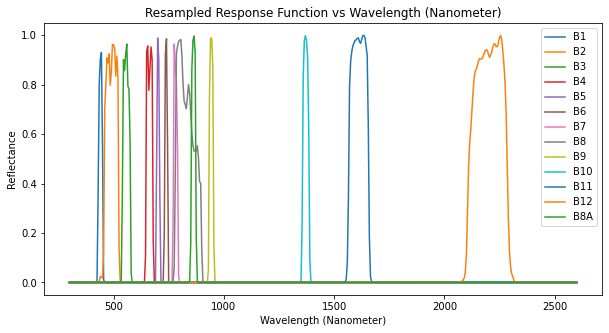

In [510]:
# Plotting our camera response function

plt.figure(figsize=(10,5))
plt.title('Resampled Response Function vs Wavelength (Nanometer)')

plt.plot(df1.index, df1['S2A_SR_AV_B1'], label='B1')

for i in range(2,13):
    plt.plot(df1[f'S2A_SR_AV_B{i}'], label=f'B{i}')

plt.plot(df1['S2A_SR_AV_B8A'], label = 'B8A')

plt.legend(loc="upper right")
plt.xlabel('Wavelength (Nanometer)')
plt.ylabel('Reflectance')
plt.show()

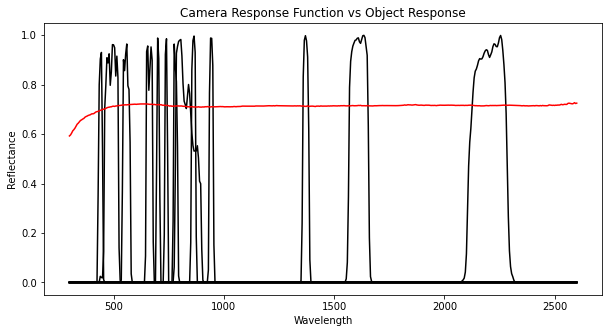

In [511]:
# Plotting our material reflectance and the camera response function

plt.figure(figsize=(10,5))
plt.title('Camera Response Function vs Object Response')

plt.plot(df1.index, df1['S2A_SR_AV_B1'], label='B1',color='black')

for i in range(2,13):
    plt.plot(df1[f'S2A_SR_AV_B{i}'], label=f'B{i}', color='black')

plt.plot(df1['S2A_SR_AV_B8A'], label = 'B8A', color='black')

plt.xlabel('Wavelength')
plt.ylabel('Reflectance')

# Group by wavelength and take the mean
plt.plot(gbw['reflectance'].loc[gbw.index <= 3000], color='red')
plt.show()

In [512]:
def get_weighted_sum(material_df,band_name):
    
    weight_sum = 0
    missing_idx = set()

    for wv, row in material_df.iterrows():
        try:
            if df1.at[wv, band_name] > 0:
                weight_sum += (row['reflectance'] * df1.at[wv, band_name])
#                 print(f"Wavelength {wv} : {row['reflectance']} * {df1.at[wv, band_name]}")
        except KeyError:
#            print(f'Key {wv} not found')
            missing_idx.add(wv)
            continue
    
#     print(f'Missing wavelength: {missing_idx} with length {len(missing_idx)}')
    return weight_sum, missing_idx

In [513]:
weighted_sums = []
for band_name in df1.columns:
    wsum, missing = get_weighted_sum(gbw,band_name)
    weighted_sums.append(wsum)

weighted_sums

[2.4646984248163557,
 8.28262234892636,
 4.457625049864843,
 4.074862663052202,
 1.9357491360693524,
 1.8929524084549036,
 2.4803262599149543,
 12.074475262968727,
 2.925002042922608,
 2.7160108438069113,
 4.03692174365852,
 12.549460449364199,
 22.91746289887448]

In [514]:
# Putting it all together in one function

def get_all_weighted_sums_from_file(file_path, highlight_missing = False):
    
    df = pd.read_table(file_path, sep='\t', skiprows=2, names = ['wavelength', 'reflectance'])

    # Convert wavelength from micron to nanometer
    df['wavelength'] = df['wavelength'].apply(lambda x: int(x * 1000))
    
    # Group by wavelength to use wavelength as index
    grouped_by_wavelength = df.groupby('wavelength').mean()
    grouped_by_wavelength = grouped_by_wavelength.loc[grouped_by_wavelength.index <= 2600]
    
    
    weighted_sums = []
    for band_name in df1.columns:
        wsum, missing = get_weighted_sum(grouped_by_wavelength,band_name)
        weighted_sums.append(wsum)
   
    print(f'There are {len(missing)} missing wavelengths in the material function')
    
     
    if highlight_missing:
        print(f'Missing wavelength: {missing} with length {len(missing)}')
    
    return weighted_sums

In [515]:
# Testing on some materials
file_path = 'RelabDatabase2020Dec31/data/asr/sr/bkr1sr030.txt'
get_all_weighted_sums_from_file(file_path)

There are 1347 missing wavelengths in the material function


[1.1421568436841025,
 4.121416287375569,
 2.2727990490195538,
 2.0993047032323022,
 1.004835192046153,
 0.9929409615017443,
 1.3307845864741907,
 6.53257258784841,
 1.5834196468522037,
 1.4541736296856216,
 2.07310600310225,
 6.52605528371307,
 10.862512869561135]

In [516]:
# Testing on other material
file_path = 'RelabDatabase2020Dec31/data/jeh/pq/capq03.txt'
get_all_weighted_sums_from_file(file_path, highlight_missing = True)

There are 4 missing wavelengths in the material function
Missing wavelength: {2009, 1004, 2029, 1014} with length 4


[2.4646984248163557,
 8.28262234892636,
 4.457625049864843,
 4.074862663052202,
 1.9357491360693524,
 1.8929524084549036,
 2.4803262599149543,
 12.074475262968727,
 2.925002042922608,
 2.7160108438069113,
 4.03692174365852,
 12.549460449364199,
 22.91746289887448]

In [504]:
file_path = 'RelabDatabase2020Dec31/data/awb/mt/bkr1mt168a.txt'
get_all_weighted_sums_from_file(file_path)

There are 39 missing wavelengths in the material function


[6.365565458135847,
 23.742610754692453,
 14.714908227577858,
 14.18662198789808,
 6.8684851482265366,
 6.711534607304084,
 7.777037349516522,
 27.858373474800278,
 5.220052920969837,
 4.143978704215992,
 15.435813262023753,
 36.10066135723287,
 62.01993008309033]